## Setup

In [2]:
import pandas as pd
import pyarrow as pa
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:

df = pd.read_parquet("data/georgia_complete_dataset.parquet")

df.head()

,time,icao24,callsign,latitude,longitude,altitude,velocity,heading,vertrate,onground
0,2025-01-14 09:52:25+00:00,a4080c,UPS1302,33.821091,-84.241931,1874.52,146.111153,162.585803,-12.02944,False
1,2025-01-14 09:52:26+00:00,a4080c,UPS1302,33.820496,-84.241707,1874.52,145.958017,162.778493,-12.02944,False
2,2025-01-14 09:52:27+00:00,a4080c,UPS1302,33.819828,-84.241505,1866.9,145.958017,162.778493,-12.02944,False
3,2025-01-14 09:52:28+00:00,a4080c,UPS1302,33.819828,-84.241505,1866.9,145.958017,162.778493,-12.02944,False
4,2025-01-14 09:52:29+00:00,a4080c,UPS1302,33.819828,-84.241505,1866.9,145.958017,162.778493,-12.02944,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9474978 entries, 0 to 9474977
Data columns (total 10 columns):
 #   Column     Dtype                         
---  ------     -----                         
 0   time       timestamp[ns, tz=UTC][pyarrow]
 1   icao24     string                        
 2   callsign   string                        
 3   latitude   double[pyarrow]               
 4   longitude  double[pyarrow]               
 5   altitude   double[pyarrow]               
 6   velocity   double[pyarrow]               
 7   heading    double[pyarrow]               
 8   vertrate   double[pyarrow]               
 9   onground   bool[pyarrow]                 
dtypes: bool[pyarrow](1), double[pyarrow](6), string(2), timestamp[ns, tz=UTC][pyarrow](1)
memory usage: 771.1 MB


In [5]:
print(f"The number of unique aircraft: {df.icao24.nunique()}")

The number of unique aircraft: 3262


In [6]:
# find the time bounds of the data
time_min = df.time.min()
time_max = df.time.max()
time_range = time_max - time_min

print(f"The time bounds of the data: {time_min} to {time_max}")
print(f"Time range: {time_range}")


The time bounds of the data: 2025-01-14 09:52:25+00:00 to 2025-01-14 20:59:59+00:00
Time range: 0 days 11:07:34


## Univariate Analysis 

Exploring the numerical features - altitude, speed, vertical rate, etc.

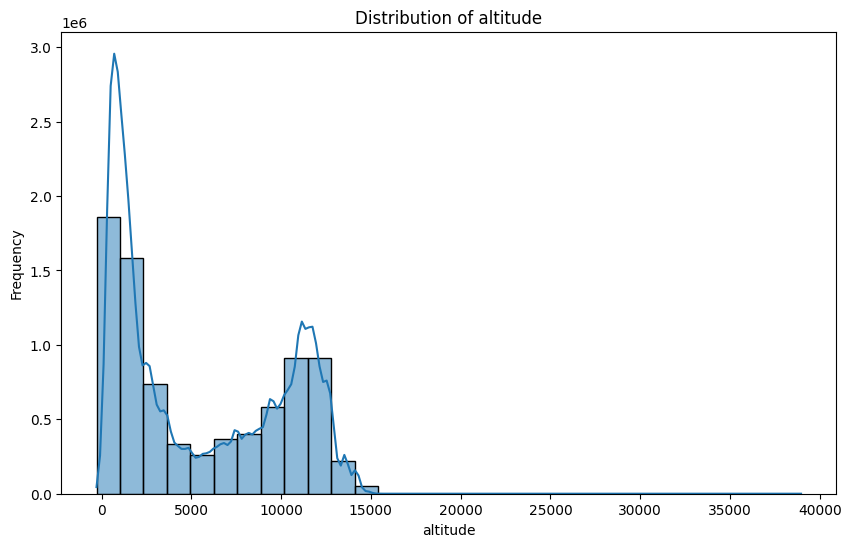

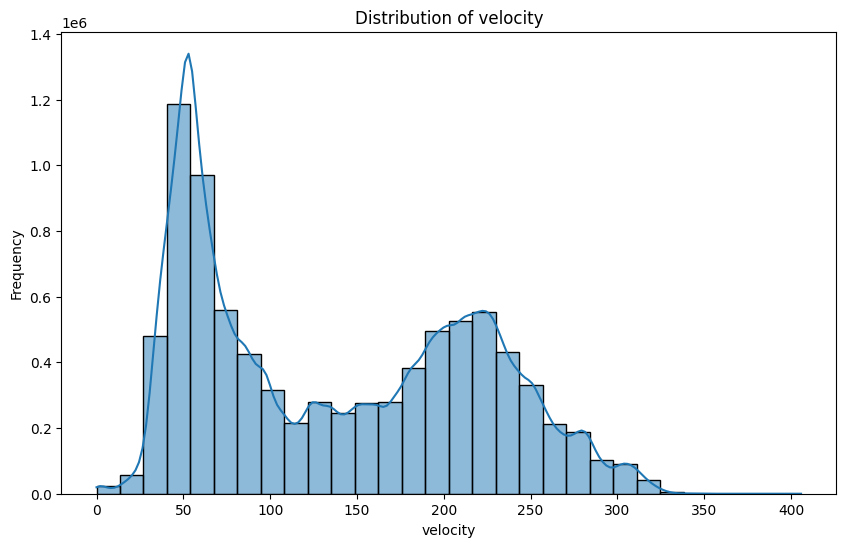

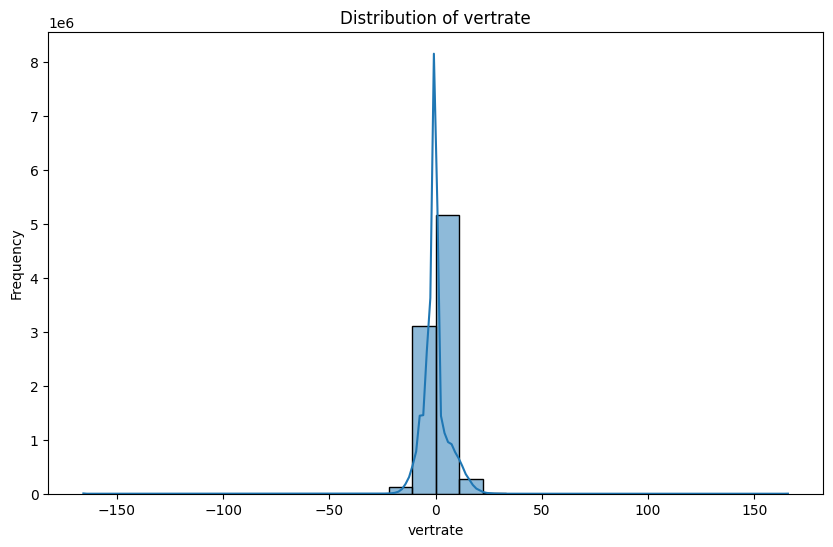

In [23]:
# Plotting histograms for each numerical feature
numerical_features = ['altitude', 'velocity', 'vertrate']
for feature in numerical_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

## Visualizing Flight Paths

Tracking a single aircraft - simple method using matplotlib

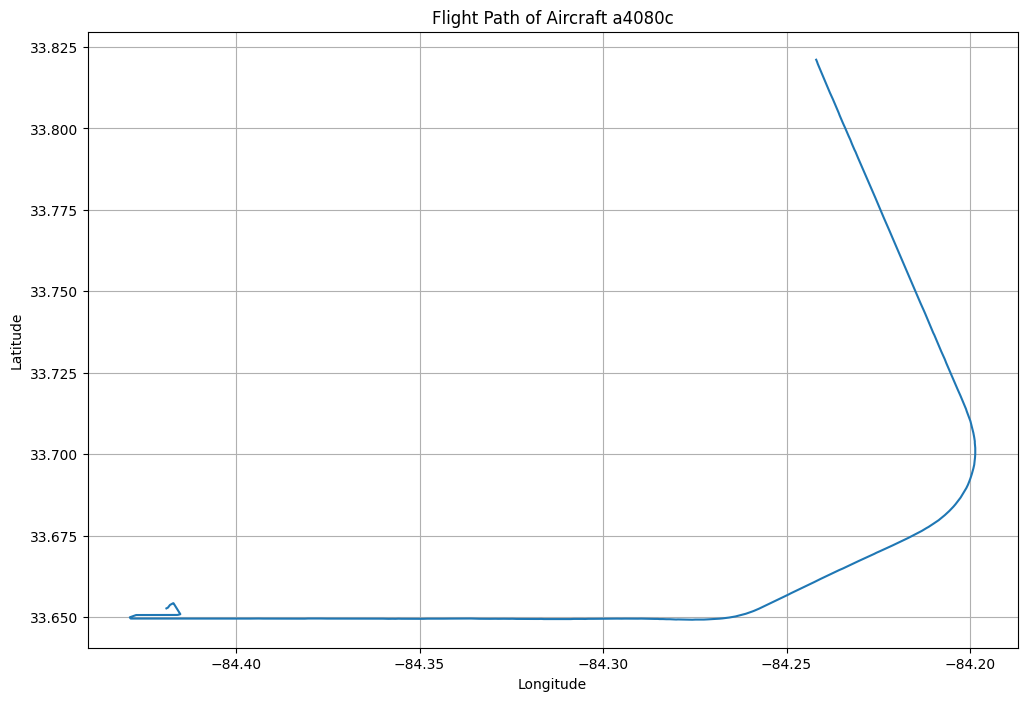

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import folium  # for interactive map visualization

# Filter for a single aircraft
icao24_to_track = 'a4080c'  # This is the aircraft ID from your data
single_aircraft = df[df['icao24'] == icao24_to_track].copy()

# Sort by time to ensure proper trajectory plotting
single_aircraft = single_aircraft.sort_values('time')

# Method 1: Simple Matplotlib plot
plt.figure(figsize=(12, 8))
plt.plot(single_aircraft['longitude'], single_aircraft['latitude'])
plt.title(f'Flight Path of Aircraft {icao24_to_track}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


Interactive map using Folium

In [16]:

# Method 2: Interactive Map with Folium (recommended)
m = folium.Map(
    location=[single_aircraft['latitude'].mean(), 
              single_aircraft['longitude'].mean()],
    zoom_start=6
)

# Add the flight path
points = list(zip(single_aircraft['latitude'], 
                 single_aircraft['longitude']))
folium.PolyLine(
    points,
    weight=2,
    color='red',
    opacity=0.8
).add_to(m)

# Add markers for start and end points
folium.Marker(
    points[0],
    popup='Start',
    icon=folium.Icon(color='green')
).add_to(m)

folium.Marker(
    points[-1],
    popup='End',
    icon=folium.Icon(color='red')
).add_to(m)

# Display the map
m

## Unsupervised Learning 

- Clustering

In [8]:
# First, let's create a function to calculate flight characteristics
import numpy as np
from scipy.stats import circmean
from math import atan2, degrees
from sklearn.preprocessing import StandardScaler

def calculate_trajectory_features(trajectory_df):
    """
    Calculate features for a single aircraft trajectory
    """
    # Sort by time to ensure proper calculations
    trajectory_df = trajectory_df.sort_values('time')
    
    # Basic statistical features
    features = {
        'avg_altitude': trajectory_df['altitude'].mean(),
        'alt_std': trajectory_df['altitude'].std(),
        'avg_velocity': trajectory_df['velocity'].mean(),
        'vel_std': trajectory_df['velocity'].std(),
        'flight_duration': (trajectory_df['time'].max() - trajectory_df['time'].min()).total_seconds(),
        'path_length': len(trajectory_df)
    }
    
    # Calculate heading changes
    lat_rad = np.radians(trajectory_df['latitude'])
    lon_rad = np.radians(trajectory_df['longitude'])
    
    # Calculate heading for each consecutive point
    headings = []
    for i in range(len(trajectory_df)-1):
        dy = lat_rad.iloc[i+1] - lat_rad.iloc[i]
        dx = lon_rad.iloc[i+1] - lon_rad.iloc[i]
        heading = degrees(atan2(dy, dx)) % 360
        headings.append(heading)
    
    if headings:
        features['avg_heading'] = np.mean(headings)
        features['heading_changes'] = np.std(headings)
    
    return features

# Create feature matrix for all aircraft
def create_feature_matrix(df):
    all_features = []
    
    # Group by aircraft
    for icao24, trajectory in df.groupby('icao24'):
        features = calculate_trajectory_features(trajectory)
        features['icao24'] = icao24
        all_features.append(features)
    
    return pd.DataFrame(all_features)

# Create the feature matrix
feature_matrix = create_feature_matrix(df)

# Handle missing values before scaling
# Option 1: Remove rows with any missing values
feature_matrix = feature_matrix.dropna()

# OR Option 2: Fill missing values with mean/median
# feature_matrix = feature_matrix.fillna(feature_matrix.mean())

# Select numerical columns for clustering
numeric_columns = ['avg_altitude', 'alt_std', 'avg_velocity', 'vel_std', 
                  'flight_duration', 'path_length', 'avg_heading', 'heading_changes']

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_matrix[numeric_columns])



Cluster sizes:
cluster
0    1293
4     784
3     598
1     313
2     253
Name: count, dtype: int64


In [ ]:

# Perform K-means clustering
from sklearn.cluster import KMeans

n_clusters = 5  # You can adjust this number
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
feature_matrix['cluster'] = kmeans.fit_predict(scaled_features)

# Display results
print("\nCluster sizes:")
print(feature_matrix['cluster'].value_counts())


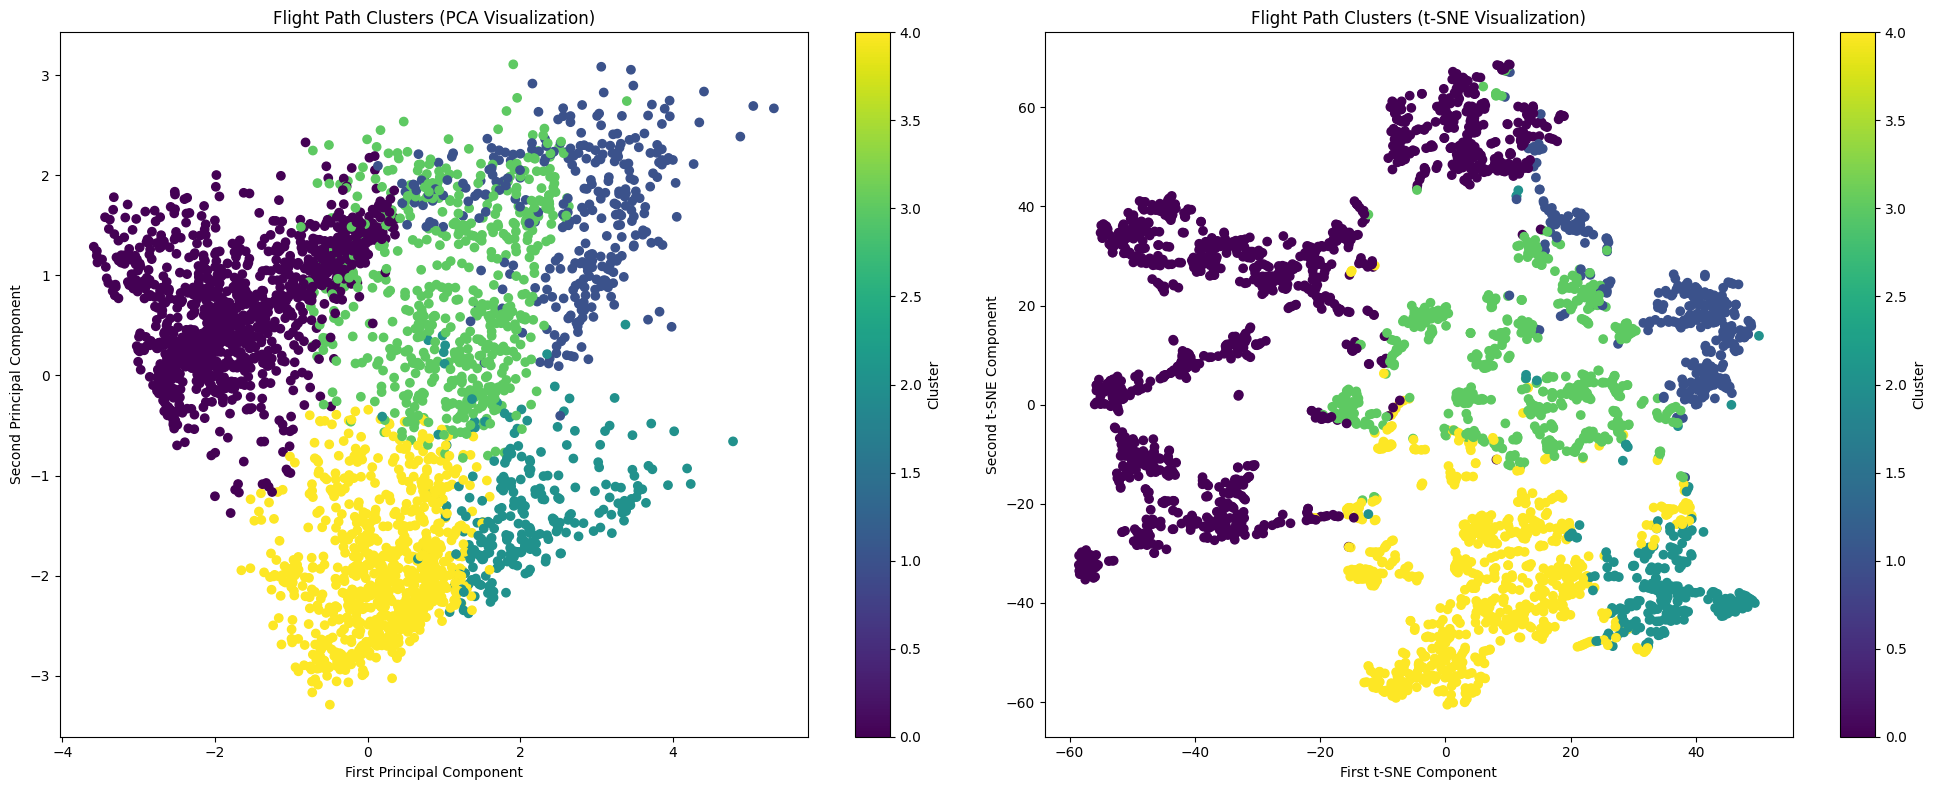

In [11]:
# Visualize clusters using both PCA and t-SNE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
plt.figure(figsize=(20, 8))

# PCA Plot
plt.subplot(1, 2, 1)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)
scatter_pca = plt.scatter(pca_result[:, 0], pca_result[:, 1], 
                         c=feature_matrix['cluster'], cmap='viridis')
plt.title('Flight Path Clusters (PCA Visualization)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter_pca, label='Cluster')

# t-SNE Plot
plt.subplot(1, 2, 2)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_result = tsne.fit_transform(scaled_features)
scatter_tsne = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], 
                          c=feature_matrix['cluster'], cmap='viridis')
plt.title('Flight Path Clusters (t-SNE Visualization)')
plt.xlabel('First t-SNE Component')
plt.ylabel('Second t-SNE Component')
plt.colorbar(scatter_tsne, label='Cluster')

plt.tight_layout()
plt.show()

In [10]:
# Analyze cluster characteristics
cluster_stats = feature_matrix.groupby('cluster')[numeric_columns].mean()
print("\nCluster characteristics:")
print(cluster_stats)


Cluster characteristics:
         avg_altitude      alt_std avg_velocity    vel_std  flight_duration  \
cluster                                                                       
0        11040.351048   462.230913   227.588933  11.629623      4996.423047   
1         5763.686129  2791.315493   163.433785  60.323287     25392.354633   
2         1416.862783   551.704328    61.962618  12.760358     18197.624506   
3         5349.777815  2832.048674   161.072609  50.746955      6645.704013   
4         1578.635594   374.044598    78.840446  10.912339      3761.395408   

         path_length  avg_heading  heading_changes  
cluster                                             
0        1677.222738   172.348605        52.997089  
1        6636.274760   119.644203       106.386019  
2        8124.470356    96.937814       106.175467  
3        2890.476589   125.840919        99.431825  
4        1801.755102    83.533824        84.321346  
